In [47]:
import matplotlib.pyplot as plt
import pandas as pd

from utils import data_utils as du
from utils import plot_utils as pu
from utils import stats_utils as su

In [ ]:
END_YEAR: int = 2023
LOW_RATING_THRESHOLD = 50
IMPROVEMENT_THRESHOLD = 10
BASELINE_YEAR = 2018
PLACARD_YEAR = 2019
POLICY_YEAR = 2019


energy_data = du.load_data()
concurrent_df = du.concurrent_buildings(
    input_df=energy_data,
    start_year=2016,
    end_year=2023,
)
did_df = su.prepare_did_data(concurrent_df)

did_df["Post"] = (did_df["Data Year"] >= POLICY_YEAR).astype(int)
median_rating = did_df["Chicago Energy Rating"].median(skipna=True)
did_df["LowRating"] = (did_df["Chicago Energy Rating"] <= median_rating).astype(int)
median_score = did_df["ENERGY STAR Score"].median(skipna=True)

## ENERGY STAR Score breakdown

It's essentially a $\text{normalized inverse}$ of energy intensity:

$$
\text{Efficiency Ratio} = 
\frac{\text{Actual - Predicted Source EUI}}{\text{Predicted Source EUI}}
\;\Rightarrow\;
\text{Score} = f\!\left(\frac{1}{\text{Efficiency Ratio}}\right)
$$



https://portfoliomanager.energystar.gov/pdf/reference/ENERGY%20STAR%20Score.pdf \
https://www.energystar.gov/buildings/benchmark/understand-metrics/source-site-difference

A ENERGY STAR of 50 means national medain per year.

On Page 3, 'A regression equation for each property type is used to determine predicted source EUI', having the regression equation might be helpful for our analysis of Chicago Placard analysis.

### Revised DiD Model

In [23]:
did_df["LowRating"] = (did_df["ENERGY STAR Score"] < median_score).astype(int)

model_eui = su.run_did_regression(
    did_df, "Site EUI (kBtu/sq ft)", log=True, include_data_year=True
)
su.summarize_did_results(model_eui)

/project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,coef,std_err,p_value,Significance
C(Q('Primary Property Type'))[T.fitness center/health club/gym],1.636000e-01,1.130000e-01,0.1478,
C(Q('Primary Property Type'))[T.hospital (general medical & surgical)],4.362000e-01,1.030000e-01,0.0000,***
C(Q('Primary Property Type'))[T.laboratory],9.298000e-01,1.152000e-01,0.0000,***
C(Q('Primary Property Type'))[T.other - specialty hospital],5.495000e-01,1.052000e-01,0.0000,***
Post,-3.665341e+10,4.867451e+10,0.4514,
LowRating,3.004000e-01,8.000000e-03,0.0000,***
Interaction,2.268000e-01,1.000000e-02,0.0000,***
ln_FloorArea,9.767000e-01,3.900000e-03,0.0000,***


In [ ]:
did_df["LowRating"] = (did_df["ENERGY STAR Score"] < LOW_RATING_THRESHOLD).astype(int)

model_eui_n = su.run_did_regression(
    did_df, "Site EUI (kBtu/sq ft)", include_data_year=True
)
su.summarize_did_results(model_eui_n)

/project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,coef,std_err,p_value,Significance
C(Q('Primary Property Type'))[T.fitness center/health club/gym],3.300660e+01,1.422880e+01,0.0204,**
C(Q('Primary Property Type'))[T.hospital (general medical & surgical)],1.231569e+02,1.640230e+01,0.0000,***
C(Q('Primary Property Type'))[T.laboratory],2.249356e+02,2.225560e+01,0.0000,***
C(Q('Primary Property Type'))[T.other - specialty hospital],8.855450e+01,1.325680e+01,0.0000,***
Post,-9.310885e+12,5.396290e+12,0.0845,*
LowRating,1.937100e+01,2.560300e+00,0.0000,***
Interaction,2.198770e+01,2.966300e+00,0.0000,***
ln_FloorArea,-3.436200e+00,3.647000e-01,0.0000,***


## Chicago Energy Rating

4 Stars: Score of 81–100 or score of 61–80 and a 10-point improvement in the past 2 years*

3.5 Stars: Score of 71–80 or score of 51–60 and a 10-point improvement in the past 2 years

3 Stars: Score of 61–70 or score of 41–50 and a 10-point improvement in the past 2 years

2.5 Stars: Score of 51–60 or score of 31–40 and a 10-point improvement in the past 2 years

2 Stars: Score of 41–50 or score of 11–30 and a 10-point improvement in the past 2 years

1.5 Stars: Score of 31–40

1 Star: Score of 1–30

0 Star: Did not submit required benchmarking information

In [ ]:
ratings_df = did_df.copy().sort_values(["ID", "Data Year"])
ratings_df["Score_Change_1yr"] = ratings_df.groupby("ID")["ENERGY STAR Score"].diff()
ratings_df["Score_Change_2yr"] = ratings_df.groupby("ID")["ENERGY STAR Score"].diff(
    periods=2
)

ratings_df["Bonus_Improvement"] = (
    ratings_df["Score_Change_2yr"] >= IMPROVEMENT_THRESHOLD
).astype(int)
ratings_df["BonusFlag"] = ratings_df["Bonus_Improvement"].replace({1: 9, 0: 0})

ratings_df["Bonus_ThisYear"] = 0

for _bid, group in ratings_df.groupby("ID"):
    idx = group.index
    improved_years = group.loc[
        group["Score_Change_2yr"] >= IMPROVEMENT_THRESHOLD, "Data Year"
    ]

    ratings_df.loc[
        idx.intersection(
            group.index[group["Score_Change_2yr"] >= IMPROVEMENT_THRESHOLD]
        ),
        "Bonus_ThisYear",
    ] = 1

ratings_df[
    [
        "ID",
        "Data Year",
        "ENERGY STAR Score",
        "Score_Change_1yr",
        "Score_Change_2yr",
        "Bonus_Improvement",
        "Bonus_ThisYear",
    ]
].head(15)

,ID,Data Year,ENERGY STAR Score,Score_Change_1yr,Score_Change_2yr,Bonus_Improvement,Bonus_ThisYear
14580,100068,2018,NaN,NaN,NaN,0,0
4390,100068,2019,NaN,NaN,NaN,0,0
21608,100068,2020,NaN,NaN,NaN,0,0
10061,100068,2021,NaN,NaN,NaN,0,0
17900,100068,2022,NaN,NaN,NaN,0,0
27658,100068,2023,NaN,NaN,NaN,0,0
12024,100148,2018,15.0,NaN,NaN,0,0
11662,100179,2018,56.0,NaN,NaN,0,0
19692,100179,2020,55.0,-1.0,NaN,0,0
7968,100179,2021,56.0,1.0,0.0,0,0


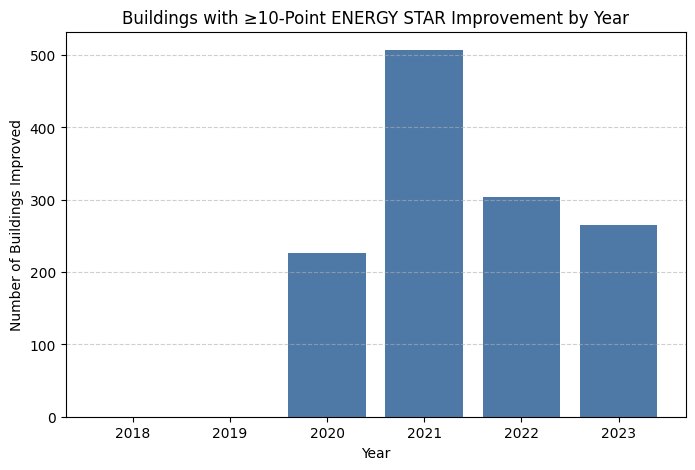

In [ ]:
improvement_counts = (
    ratings_df.groupby("Data Year")["Bonus_ThisYear"]
    .sum()
    .reset_index(name="Num_Buildings_Improved")
)
total_counts = (
    ratings_df.groupby("Data Year")["ID"].count().reset_index(name="Total_Buildings")
)
improvement_summary = improvement_counts.merge(total_counts, on="Data Year")
improvement_summary["Percent_Improved"] = (
    100
    * improvement_summary["Num_Buildings_Improved"]
    / improvement_summary["Total_Buildings"]
).round(2)

plt.figure(figsize=(8, 5))
plt.bar(
    improvement_summary["Data Year"],
    improvement_summary["Num_Buildings_Improved"],
    color="#4e79a7",
)
plt.title("Buildings with ≥10-Point ENERGY STAR Improvement by Year")
plt.xlabel("Year")
plt.ylabel("Number of Buildings Improved")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

## Other Cities Data Analysis

### Other Cities Data Analysis

In [56]:
national_data = {
    "Data Year": [2018, 2019, 2020, 2021, 2022, 2023],
    "National_Mean_Source_EUI": [205.9, 202.1, 187.4, 186.5, 185.5, 180.5],
    "National_Median_Source_EUI": [142.1, 138.7, 124.1, 121.8, 118.1, 114.1],
}

national_eui_df = pd.DataFrame(national_data)

national_eui_df["YoY_Change_Mean_%"] = (
    national_eui_df["National_Mean_Source_EUI"].pct_change() * 100
)
national_eui_df["YoY_Change_Median_%"] = (
    national_eui_df["National_Median_Source_EUI"].pct_change() * 100
)

national_eui_df

,Data Year,National_Mean_Source_EUI,National_Median_Source_EUI,YoY_Change_Mean_%,YoY_Change_Median_%
0,2018,205.9,142.1,NaN,NaN
1,2019,202.1,138.7,-1.845556,-2.392681
2,2020,187.4,124.1,-7.273627,-10.526316
3,2021,186.5,121.8,-0.480256,-1.853344
4,2022,185.5,118.1,-0.536193,-3.037767
5,2023,180.5,114.1,-2.695418,-3.386960


In [ ]:
chicago_df = ratings_df.groupby("Data Year", as_index=False)[
    "Source EUI (kBtu/sq ft)"
].agg(Chicago_Mean_Source_EUI="mean", Chicago_Median_Source_EUI="median")
national_df = (
    national_eui_df.groupby("Data Year", as_index=False)["Source EUI (kBtu/sq ft)"]
    .mean()
    .rename(columns={"Source EUI (kBtu/sq ft)": "National_Mean_Source_EUI"})
)

compare_df = national_df.merge(chicago_df, on="Data Year", how="left")

for col in ["National_Mean_Source_EUI", "Chicago_Mean_Source_EUI"]:
    compare_df[f"{col}_pct_change"] = (
        compare_df[col]
        / compare_df.loc[compare_df["Data Year"] == BASELINE_YEAR, col].to_numpy()[0]
    ) * 100

compare_df.round(2)

,Data Year,National_Mean_Source_EUI,National_Median_Source_EUI,Chicago_Mean_Source_EUI,Chicago_Median_Source_EUI,National_Mean_Source_EUI_pct_change,Chicago_Mean_Source_EUI_pct_change
0,2018,205.9,142.1,163.45,142.00,0.00,0.00
1,2019,202.1,138.7,179.14,145.30,-1.85,9.60
2,2020,187.4,124.1,147.20,127.55,-8.98,-9.94
3,2021,186.5,121.8,149.23,128.95,-9.42,-8.70
4,2022,185.5,118.1,152.17,134.80,-9.91,-6.90
5,2023,180.5,114.1,143.25,124.10,-12.34,-12.36


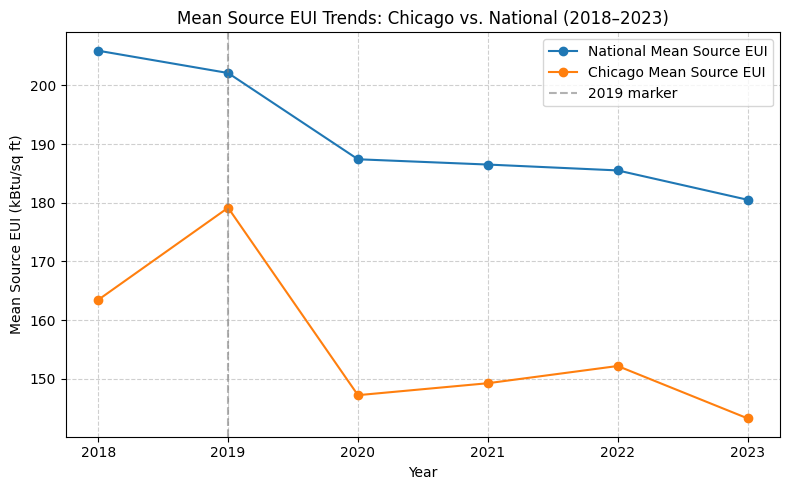

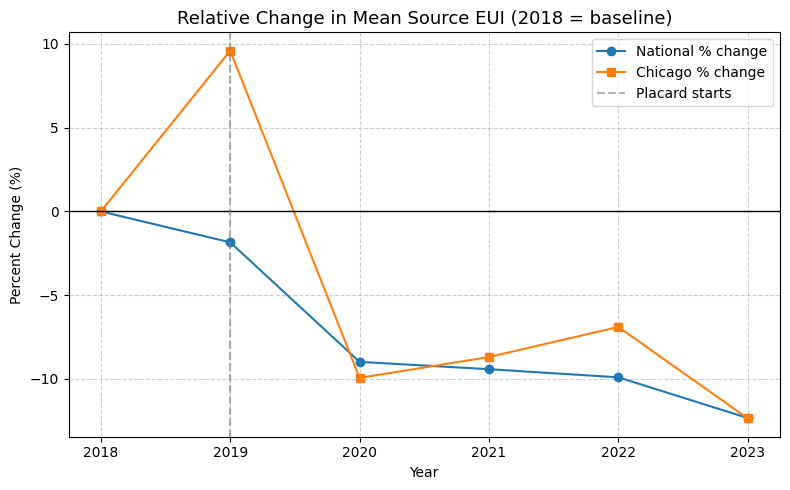

In [ ]:
pu.plot_multi_line_trend(
    df=compare_df,
    year_col="Data Year",
    line_cols=["National_Mean_Source_EUI", "Chicago_Mean_Source_EUI"],
    labels=["National Mean Source EUI", "Chicago Mean Source EUI"],
    title="Mean Source EUI Trends: Chicago vs. National (2018–2023)",
    ylabel="Mean Source EUI (kBtu/sq ft)",
    marker_year=PLACARD_YEAR,
)
pu.ative_change(
    df=compare_df,
    year_col="Data Year",
    nat_col="National_Mean_Source_EUI",
    chi_col="Chicago_Mean_Source_EUI",
    title="Relative Change in Mean Source EUI (2018 = baseline)",
)
plt.show()

In [ ]:
national_median_df = pd.DataFrame(national_data)
chicago_median_df = (
    ratings_df.groupby("Data Year", as_index=False)["Source EUI (kBtu/sq ft)"]
    .median()
    .rename(columns={"Source EUI (kBtu/sq ft)": "Chicago_Median_Source_EUI"})
)

compare_median = national_median_df.merge(chicago_median_df, on="Data Year")

compare_median["National_Median_pct_change"] = (
    compare_median["National_Median_Source_EUI"].pct_change() * 100
)
compare_median["Chicago_Median_pct_change"] = (
    compare_median["Chicago_Median_Source_EUI"].pct_change() * 100
)

compare_median["Chicago_minus_National_pct_diff"] = (
    compare_median["Chicago_Median_pct_change"]
    - compare_median["National_Median_pct_change"]
)

compare_median.round(2)

,Data Year,National_Median_Source_EUI,Chicago_Median_Source_EUI,National_Median_pct_change,Chicago_Median_pct_change,Chicago_minus_National_pct_diff
0,2018,142.1,142.00,NaN,NaN,NaN
1,2019,138.7,145.30,-2.39,2.32,4.72
2,2020,124.1,127.55,-10.53,-12.22,-1.69
3,2021,121.8,128.95,-1.85,1.10,2.95
4,2022,118.1,134.80,-3.04,4.54,7.57
5,2023,114.1,124.10,-3.39,-7.94,-4.55


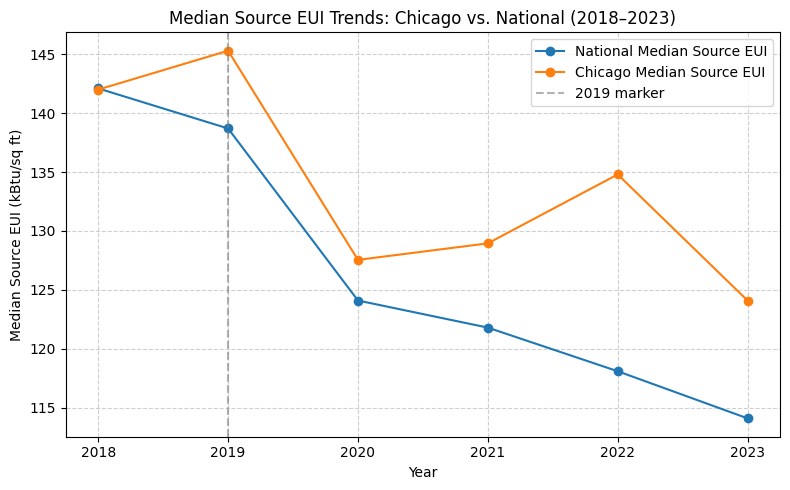

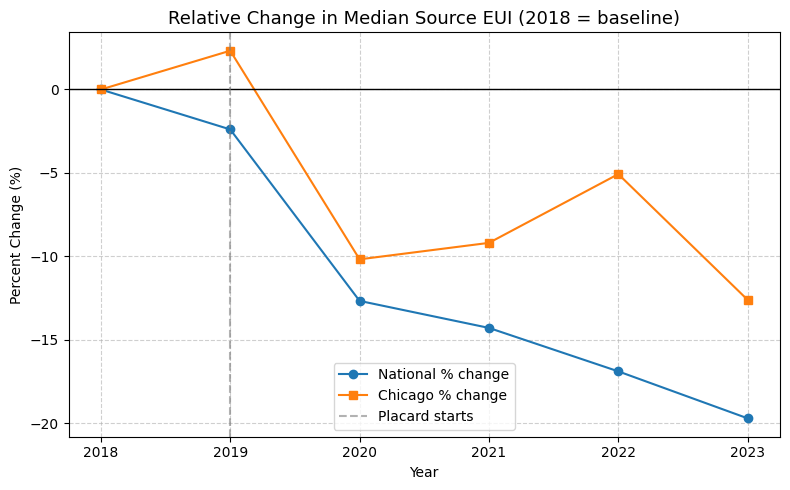

In [ ]:
pu.plot_multi_line_trend(
    df=compare_median,
    year_col="Data Year",
    line_cols=["National_Median_Source_EUI", "Chicago_Median_Source_EUI"],
    labels=["National Median Source EUI", "Chicago Median Source EUI"],
    title="Median Source EUI Trends: Chicago vs. National (2018–2023)",
    ylabel="Median Source EUI (kBtu/sq ft)",
    marker_year=PLACARD_YEAR,
)
pu.plot_relative_change(
    df=compare_median,
    year_col="Data Year",
    nat_col="National_Median_Source_EUI",
    chi_col="Chicago_Median_Source_EUI",
    title="Relative Change in Median Source EUI (2018 = baseline)",
)
plt.show()